- By: Aman Dhaliwal
- Email: amandhaliwal44@hotmail.com
- Reference: Hierarchical Risk Parity by Marcos Lopez de Prado

# Hierarchical Risk Parity with MlFinLab

## Abstract
Throughout this notebook, users will be taken through how they can construct optimal portfolios using the Hierarchical Risk Parity algorithm. Users will also be shown how to create custom use cases and how to build a Long/Short portfolio.

All calculations and algorithms will be implemented through the MlFinLab library.


## Introduction
The Hierarchical Risk Parity (HRP) algorithm was developed by Dr. Marcos Lopez de Prado in 2016. Throughout this notebook, we will go through how we can implement this algorithm through the MlFinLab library. 

The HRP algorithm is computed throughout 3 main steps:
1. Hierarchical Clustering - breaks down our assets into hierarchical clusters
2. Quasi-Diagonalization - reorganizes the covariance matrix, placing similar assets together
3. Recursive Bisection - weights are assigned to each asset in our portfolio

For a detailed explanation behind the theory of this algorithm, please refer to __[this blog post](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__ where it is explained in detail. Additionally, please refer to the  __[official HRP documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_risk_parity.html)__ to learn more about this specific implementation through the MlFinLab library.

### Support Linkage Methods
MlFinLab allows users to customize the type of linkage algorithm for the use of clustering. The current supported linkage methods are:
1. Single Linkage - the distance between two clusters is the minimum distance between any two points in the clusters
2. Complete Linkage - the distance between two clusters is the maximum of the distance between any two points in the clusters
3. Average Linkage - the distance between two clusters is the average of the distance between any two points in the clusters
4. Ward Linkage - the distance between two clusters is the increase of the squared error from when two clusters are merged

**The default linkage method in MlFinLab is set as the Single Linkage method.**


In [22]:
# importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from mlfinlab.portfolio_optimization import ReturnsEstimators
from mlfinlab.portfolio_optimization import HierarchicalRiskParity

## The Data

In this tutorial, we will be working with the historical closing prices for 17 assets from 2010-2018. The data we are working with was chosen because the clustering structure is clearly visible so it is a very good dataset for working with and visualizing various clustering techniques.

In [71]:
# preparing our data
raw_prices = pd.read_csv("../../Sample-Data/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
stock_prices = raw_prices.sort_values(by='Dates')
stock_prices.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21


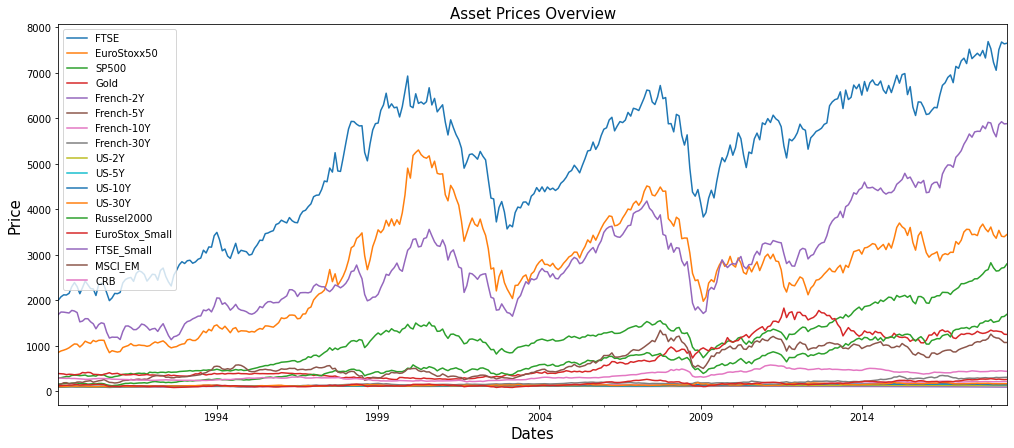

In [33]:
# Taking a quick look at our most recent 5000 data points
stock_prices.resample('M').last().plot(figsize=(17,7))
plt.ylabel('Price', size=15)
plt.xlabel('Dates', size=15)
plt.title('Asset Prices Overview', size=15)
plt.show()

We can also plot the volatility of our stocks as well for further inspection.

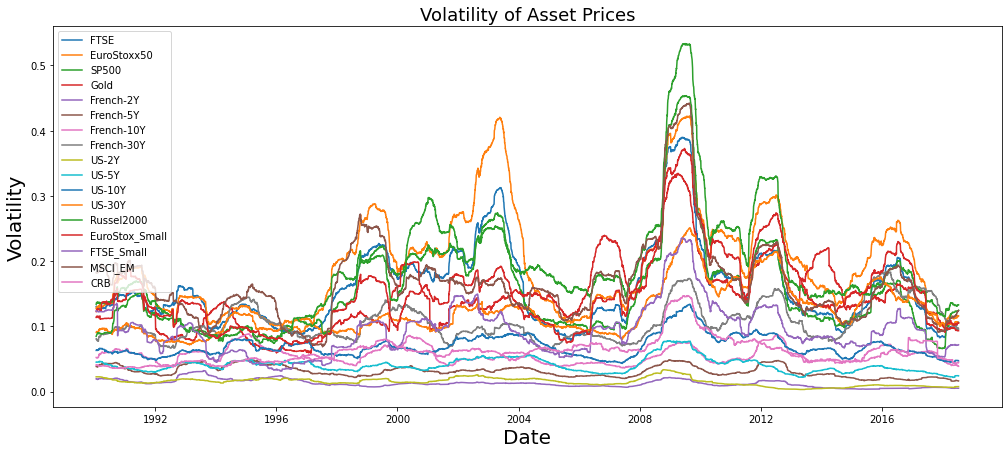

In [34]:
# plotting the volatility of our stocks
volatility = stock_prices.pct_change().rolling(window=252).std()*(252**0.5)

plt.figure(figsize=(17,7))
plt.plot(volatility)
plt.ylabel('Volatility', size=20)
plt.xlabel('Date', size=20)
plt.title('Volatility of Asset Prices', size=18)
plt.legend(stock_prices.columns, loc='upper left')
plt.show()

Additionally, we can plot the covariance matrix of our assets as well.

<Figure size 504x504 with 0 Axes>

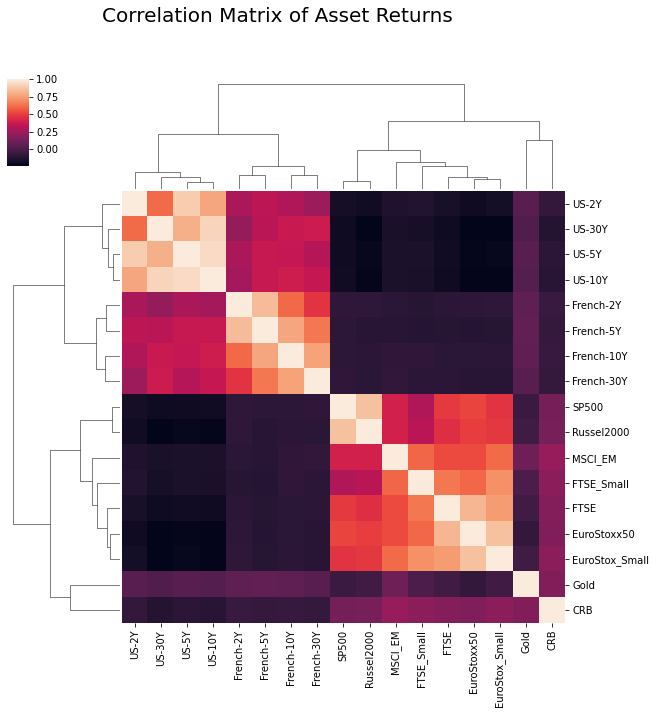

In [35]:
asset_returns = ReturnsEstimators.calculate_returns(stock_prices)
plt.figure(figsize=(7,7))
g = sns.clustermap(asset_returns.corr())
g.fig.suptitle('Correlation Matrix of Asset Returns', fontsize = 20)
plt.show()

## HRP Implementation

Throughout these examples, we will show readers how they can construct an optimal portfolio using the HRP class provided through MlFinLab.

In order to construct our optimal portfolio, we must first instantiate the HierarchicalRiskParity() class and then run the allocate() method. Please note that the allocate method requires only two parameters to run its default solution:
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)

Users are also given the option to customize many different parameters in the allocate() method, some of these include:
1. The type of linkage algorithm being used
2. Whether to shrink the covariance matrix

Additionally, instead of providing raw historical closing prices, users can choose to input asset returns, a covariance matrix, and a distance matrix instead. For simplicity, we will only be working with the two required parameters as well as specifying our linkage algorithm of choice.

Throughout this section, we will construct four optimal portfolios - one portfolio for each supported linkage algorithm.

In [36]:
# constructing our Single Linkage portfolio
hrp_single = HierarchicalRiskParity()
hrp_single.allocate(asset_names=stock_prices.columns,
                    asset_prices=stock_prices,
                    linkage='single')

print("HRP Portfolio Weights - Single Linkage \n", hrp_single.weights)

HRP Portfolio Weights - Single Linkage 
       US-2Y    US-30Y     US-5Y    US-10Y  French-30Y  French-10Y  French-2Y  \
0  0.342019  0.005462  0.031405  0.010994    0.007092     0.02637   0.447405   

   French-5Y      Gold       CRB     SP500  Russel2000   MSCI_EM  FTSE_Small  \
0   0.083377  0.004831  0.027454  0.002351     0.00173  0.001613    0.005024   

       FTSE  EuroStoxx50  EuroStox_Small  
0  0.001463     0.000535        0.000875  


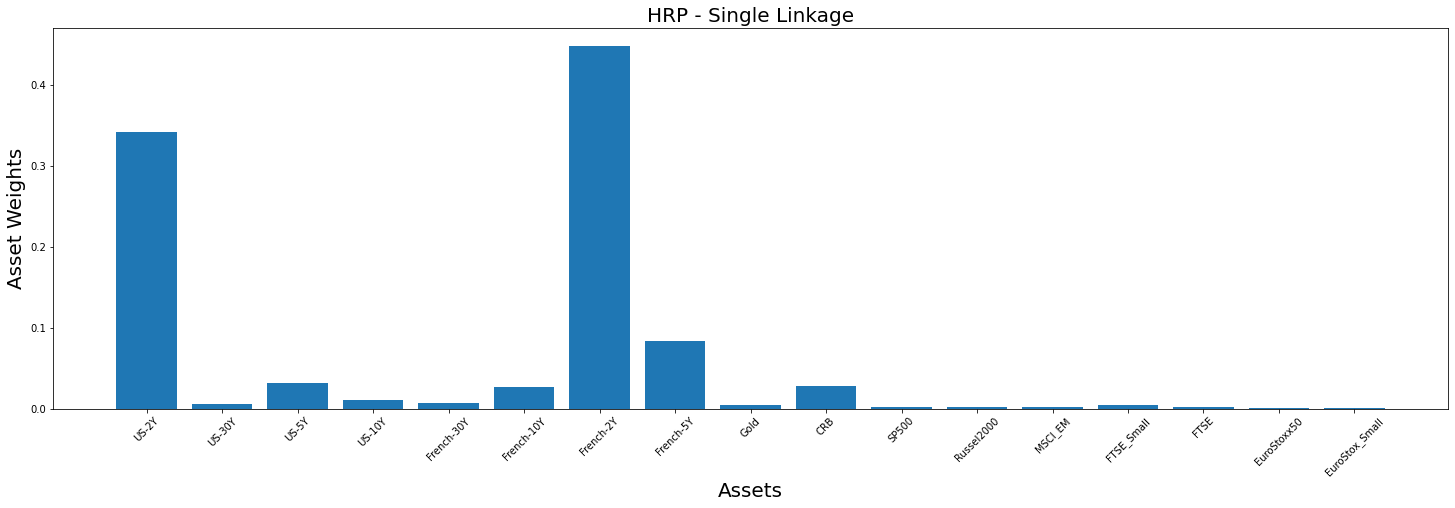

In [64]:
# plotting our optimal portfolio
hrp_single_weights = hrp_single.weights
y_pos = np.arange(len(hrp_single_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_single_weights.columns), hrp_single_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Single Linkage', size=20)
plt.show()

MlFinLab also provides users with the ability to plot their hierarchical tree from the optimized portfolio. This graph can be accessed through the plot_cluster() method.

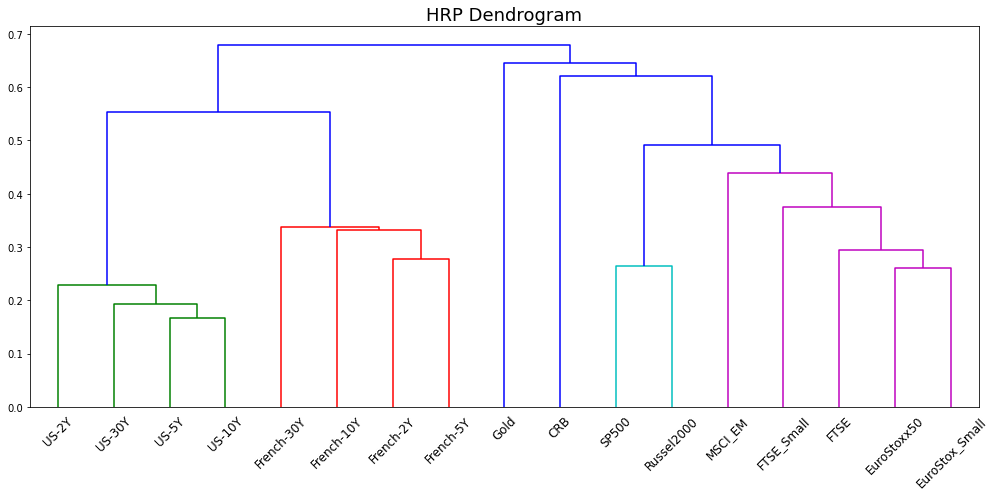

In [41]:
# plotting dendrogram of HRP portfolio
plt.figure(figsize=(17,7))
hrp_single.plot_clusters(stock_prices.columns)
plt.title('HRP Dendrogram', size=18)
plt.xticks(rotation=45)
plt.show()

In [42]:
# constructing our Complete Linkage portfolio
hrp_complete = HierarchicalRiskParity()
hrp_complete.allocate(asset_names=stock_prices.columns,
                      asset_prices=stock_prices,
                      linkage='complete')

print("HRP Portfolio Weights - Complete Linkage \n", hrp_complete.weights)

HRP Portfolio Weights - Complete Linkage 
       US-2Y    US-30Y     US-5Y    US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.342019  0.005462  0.031405  0.010994   0.447405   0.083377     0.02637   

   French-30Y     SP500  Russel2000   MSCI_EM  FTSE_Small      FTSE  \
0    0.007092  0.001989    0.001464  0.002245    0.006993  0.002146   

   EuroStoxx50  EuroStox_Small      Gold       CRB  
0     0.001443        0.003874  0.003849  0.021873  


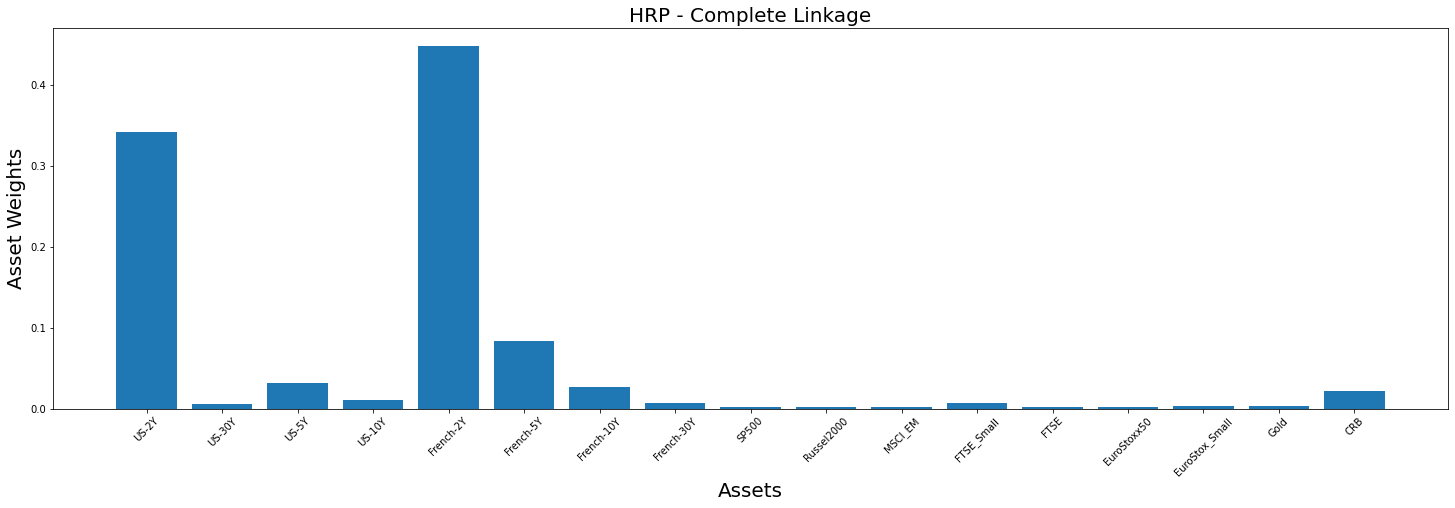

In [43]:
# plotting our optimal portfolio
hrp_complete_weights = hrp_complete.weights
y_pos = np.arange(len(hrp_complete_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_complete_weights.columns), hrp_complete_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Complete Linkage', size=20)
plt.show()

In [44]:
# constructing our Average Linkage portfolio
hrp_average = HierarchicalRiskParity()
hrp_average.allocate(asset_names=stock_prices.columns,
                     asset_prices=stock_prices,
                     linkage='average')

print("HRP Portfolio Weights - Average Linkage \n", hrp_average.weights)

HRP Portfolio Weights - Average Linkage 
         CRB     SP500  Russel2000   MSCI_EM  FTSE_Small      FTSE  \
0  0.023688  0.003356     0.00191  0.002398    0.005167  0.001826   

   EuroStoxx50  EuroStox_Small      Gold     US-2Y    US-30Y     US-5Y  \
0      0.00105        0.001717  0.004258  0.394527  0.004289  0.039091   

    US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.01678   0.439188   0.048666    0.009526    0.002562  


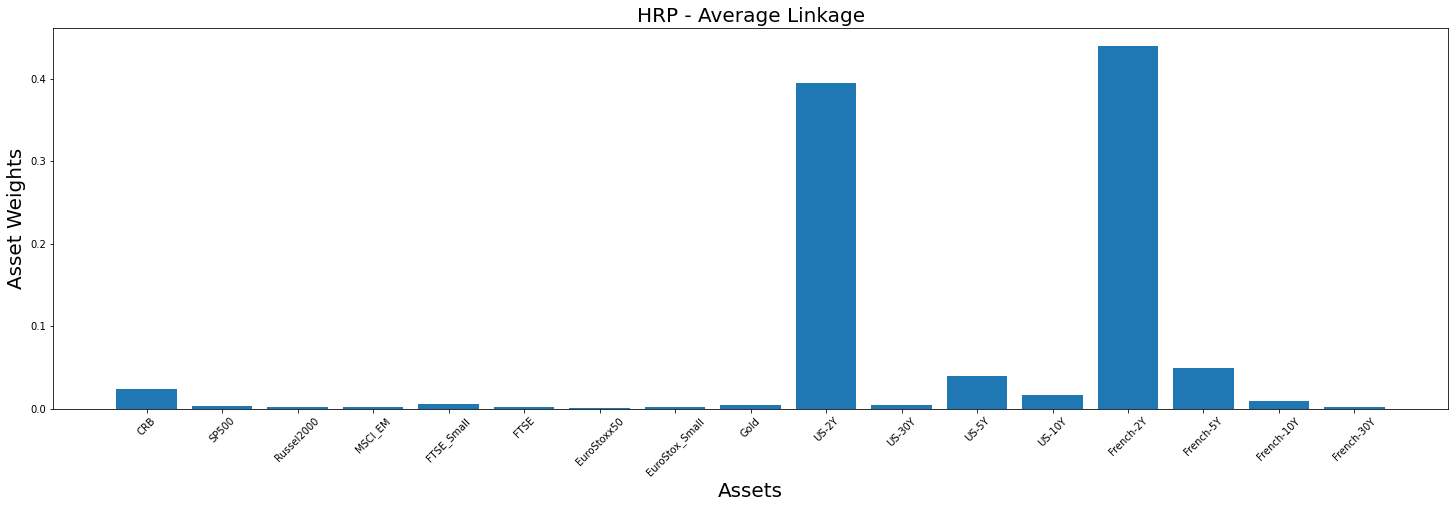

In [45]:
# plotting our optimal portfolio
hrp_average_weights = hrp_average.weights
y_pos = np.arange(len(hrp_average_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_average_weights.columns), hrp_average_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Average Linkage', size=20)
plt.show()

In [46]:
# constructing our Ward Linkage portfolio
hrp_ward = HierarchicalRiskParity()
hrp_ward.allocate(asset_names=stock_prices.columns,
                  asset_prices=stock_prices,
                  linkage='ward')

print("HRP Portfolio Weights - Ward Linkage \n", hrp_ward.weights)

HRP Portfolio Weights - Ward Linkage 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.005128  0.029138  0.002495    0.001836  0.001695      0.00114   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0         0.00205    0.005278  0.003196  0.398019  0.004188  0.038167   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.016486   0.431492   0.047813    0.009359    0.002517  


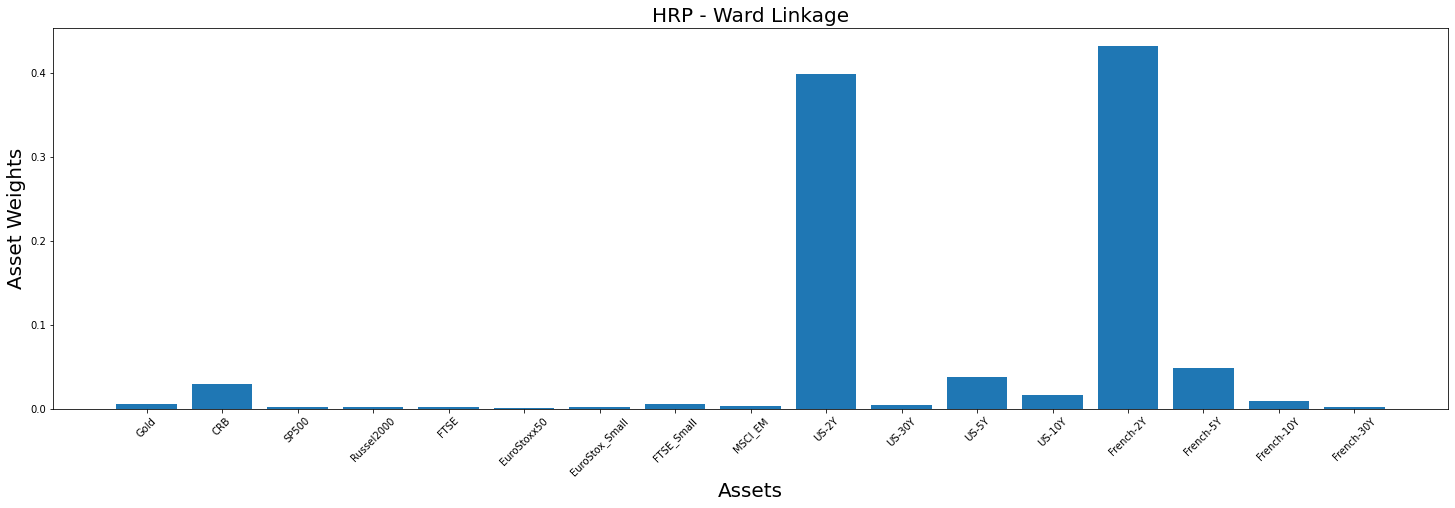

In [47]:
# plotting our optimal portfolio
hrp_ward_weights = hrp_ward.weights
y_pos = np.arange(len(hrp_ward_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_ward_weights.columns), hrp_ward_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Ward Linkage', size=20)
plt.show()

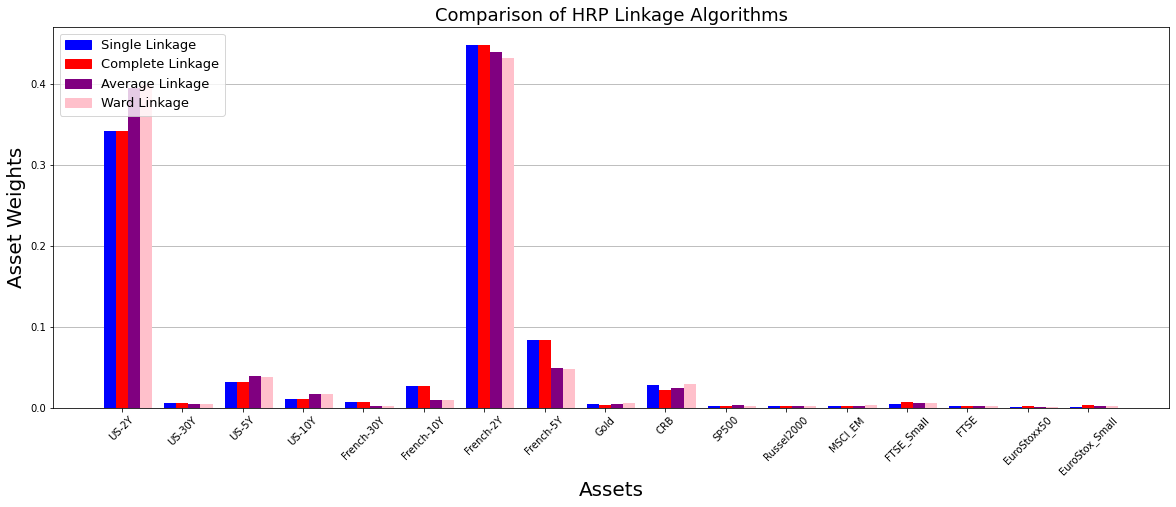

In [53]:
# Comparing different linkage methods
single_linkage_weights = hrp_single.weights
complete_linkage_weights = hrp_complete.weights[single_linkage_weights.columns]
average_linkage_weights = hrp_average.weights[single_linkage_weights.columns]
ward_linkage_weights = hrp_ward.weights[single_linkage_weights.columns]

x = np.arange(len(single_linkage_weights.columns))
bar_width = 0.2

plt.figure(figsize=(20,7))
plt.bar(x, single_linkage_weights.values[0], color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width, complete_linkage_weights.values[0], color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, average_linkage_weights.values[0], color='purple', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, ward_linkage_weights.values[0], color='pink', width=bar_width, zorder=2)

plt.xticks(x + bar_width, single_linkage_weights, rotation=45, size=10)
plt.title('Comparison of HRP Linkage Algorithms', size=18)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)

blue_patch = mpatches.Patch(color='blue', label='Single Linkage')
red_patch = mpatches.Patch(color='red', label='Complete Linkage')
purple_patch = mpatches.Patch(color='purple', label='Average Linkage')
pink_patch = mpatches.Patch(color='pink', label='Ward Linkage')
plt.legend(handles=[blue_patch, red_patch, purple_patch, pink_patch], loc='upper left', prop={'size': 13})

plt.grid(axis='y')

plt.show()

## Custom Input from Users

MlFinLab also provides users with a lot of customizability when it comes to creating their optimal portfolios. Instead of providing the raw historical closing prices for assets, users can instead input asset returns, a covariance matrix of asset returns, a distance matrix, and side weights.

In this section, we will make use of the following parameters in the allocate() method to construct a custom use case:
1. asset_returns – (pd.Dataframe/numpy matrix) User supplied matrix of asset returns
2. covariance_matrix – (pd.Dataframe/numpy matrix) User supplied covariance matrix of asset returns
3. side_weights – (pd.Series/numpy matrix) With asset_names in index and value 1 for Buy, -1 for Sell (default 1 for all)

We will be constructing our first custom portfolio using the asset_returns and covariance_matrix parameters. We will then work with the side_weights parameter to construct a Long/Short portfolio.

To make some of the necessary calculations, we will make use of the ReturnsEstimators class provided by MlFinLab.

In [54]:
# Calculating our asset returns
returns = ReturnsEstimators.calculate_returns(stock_prices)
returns.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-02-02,0.001814,0.002981,-0.000841,-0.001274,-0.001847,0.000788,-0.002953,-0.003080,-0.000310,-0.000309,-0.000623,-0.000304,0.003627,0.001617,0.003892,0.010989,0.001256
1989-02-03,0.012969,0.006844,0.000438,-0.008291,0.000091,-0.001160,-0.001340,-0.005156,-0.001880,-0.002512,-0.000950,-0.001835,0.004841,0.007902,0.009842,0.015416,-0.004878
1989-02-06,-0.012368,0.001584,-0.003132,-0.001929,-0.004277,-0.005050,-0.006405,-0.014509,0.000000,0.000000,-0.001258,-0.002458,-0.000707,0.002276,-0.001356,-0.000707,-0.003291
1989-02-07,0.013941,-0.001886,0.012127,0.012242,-0.000467,-0.001929,-0.002213,-0.000522,0.000942,0.001889,0.003472,0.006150,0.008099,-0.005131,0.003561,-0.000898,-0.001686
1989-02-08,0.011289,0.009040,-0.003271,-0.005729,0.001219,0.003519,0.004721,0.002099,-0.000941,-0.000948,-0.001266,-0.004280,0.001020,0.003805,0.011481,0.000825,0.000598


In [55]:
# Calculating our covariance matrix
cov = returns.cov()
cov

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
FTSE,1.146945e-04,0.000116,5.643606e-05,-3.081248e-06,-8.832561e-07,-2.423788e-06,-3.877263e-06,-0.000007,-1.684947e-06,-5.204467e-06,-0.000009,-0.000017,6.135381e-05,8.225258e-05,4.439900e-05,6.415264e-05,7.666681e-06
EuroStoxx50,1.156055e-04,0.000171,7.300403e-05,-8.984117e-06,-1.007815e-06,-3.028229e-06,-4.756979e-06,-0.000009,-2.485549e-06,-7.711391e-06,-0.000013,-0.000025,8.212584e-05,1.151939e-04,5.028051e-05,7.834393e-05,8.579117e-06
SP500,5.643606e-05,0.000073,1.166470e-04,-5.160036e-06,-7.911315e-07,-2.029786e-06,-3.471091e-06,-0.000006,-1.831687e-06,-5.366541e-06,-0.000009,-0.000017,1.169106e-04,5.176979e-05,2.052664e-05,4.920214e-05,5.734262e-06
Gold,-3.081248e-06,-0.000009,-5.160036e-06,9.391228e-05,5.410605e-07,1.476888e-06,2.321374e-06,0.000003,4.275486e-07,1.104387e-06,0.000001,0.000002,-3.318860e-06,-2.983680e-06,5.254349e-07,1.190630e-05,6.521527e-06
French-2Y,-8.832561e-07,-0.000001,-7.911315e-07,5.410605e-07,7.601231e-07,1.489883e-06,1.898718e-06,0.000003,2.531965e-07,6.484230e-07,0.000001,0.000002,-9.470974e-07,-7.577931e-07,-6.162087e-07,-9.918712e-07,-1.887774e-07
French-5Y,-2.423788e-06,-0.000003,-2.029786e-06,1.476888e-06,1.489883e-06,4.078881e-06,5.636027e-06,0.000009,6.932479e-07,1.962122e-06,0.000003,0.000005,-2.710612e-06,-2.274587e-06,-1.463102e-06,-2.348135e-06,-5.283503e-07
French-10Y,-3.877263e-06,-0.000005,-3.471091e-06,2.321374e-06,1.898718e-06,5.636027e-06,1.277570e-05,0.000019,1.087356e-06,3.382581e-06,0.000006,0.000011,-4.211428e-06,-3.527256e-06,-1.842464e-06,-3.291552e-06,-8.256807e-07
French-30Y,-7.056356e-06,-0.000009,-6.099633e-06,3.174908e-06,2.821258e-06,9.019102e-06,1.901961e-05,0.000048,1.680413e-06,5.734125e-06,0.000011,0.000021,-8.772903e-06,-7.540945e-06,-4.252162e-06,-5.835942e-06,-1.919975e-06
US-2Y,-1.684947e-06,-0.000002,-1.831687e-06,4.275486e-07,2.531965e-07,6.932479e-07,1.087356e-06,0.000002,1.013660e-06,2.378533e-06,0.000004,0.000005,-2.342607e-06,-1.776541e-06,-8.056344e-07,-1.494199e-06,-2.967647e-07
US-5Y,-5.204467e-06,-0.000008,-5.366541e-06,1.104387e-06,6.484230e-07,1.962122e-06,3.382581e-06,0.000006,2.378533e-06,6.964215e-06,0.000011,0.000017,-7.260984e-06,-5.806622e-06,-2.472951e-06,-4.365090e-06,-1.045403e-06


### Building our First Custom Portfolio

In [56]:
# constructing our first custom portfolio
hrp_custom = HierarchicalRiskParity()
hrp_custom.allocate(asset_names=stock_prices.columns,
                    asset_returns=returns,
                    covariance_matrix=cov)
print("Custom HRP Portfolio Weights\n", hrp_custom.weights)

Custom HRP Portfolio Weights
       US-2Y    US-30Y     US-5Y    US-10Y  French-30Y  French-10Y  French-2Y  \
0  0.342019  0.005462  0.031405  0.010994    0.007092     0.02637   0.447405   

   French-5Y      Gold       CRB     SP500  Russel2000   MSCI_EM  FTSE_Small  \
0   0.083377  0.004831  0.027454  0.002351     0.00173  0.001613    0.005024   

       FTSE  EuroStoxx50  EuroStox_Small  
0  0.001463     0.000535        0.000875  


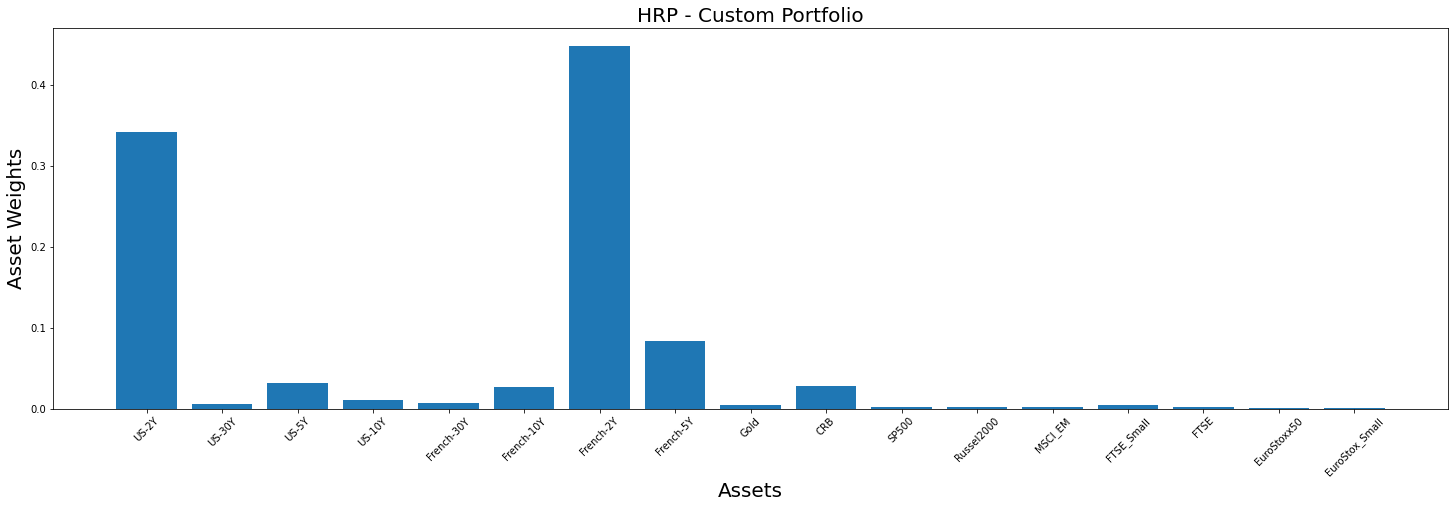

In [66]:
# plotting our optimal portfolio
hrp_custom_weights = hrp_custom.weights
y_pos = np.arange(len(hrp_custom_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_custom_weights.columns), hrp_custom_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Custom Portfolio', size=20)
plt.show()

### Using a Custom Distance Matrix
We can also use our own distance matrix to calculate our optimal portfolio. This distance matrix will be derived directly from the covariance matrix.

We can make use of the cov_to_corr() method from the RiskEstimators class to perform some of the necessary calculations.

In [58]:
from mlfinlab.portfolio_optimization import RiskEstimators

In [59]:
corr = RiskEstimators.cov_to_corr(cov)
distance = np.sqrt((1 - corr).round(5) / 2)

hrp_distance = HierarchicalRiskParity()
hrp_distance.allocate(asset_names=stock_prices.columns,
                      distance_matrix=distance, 
                      covariance_matrix=cov)

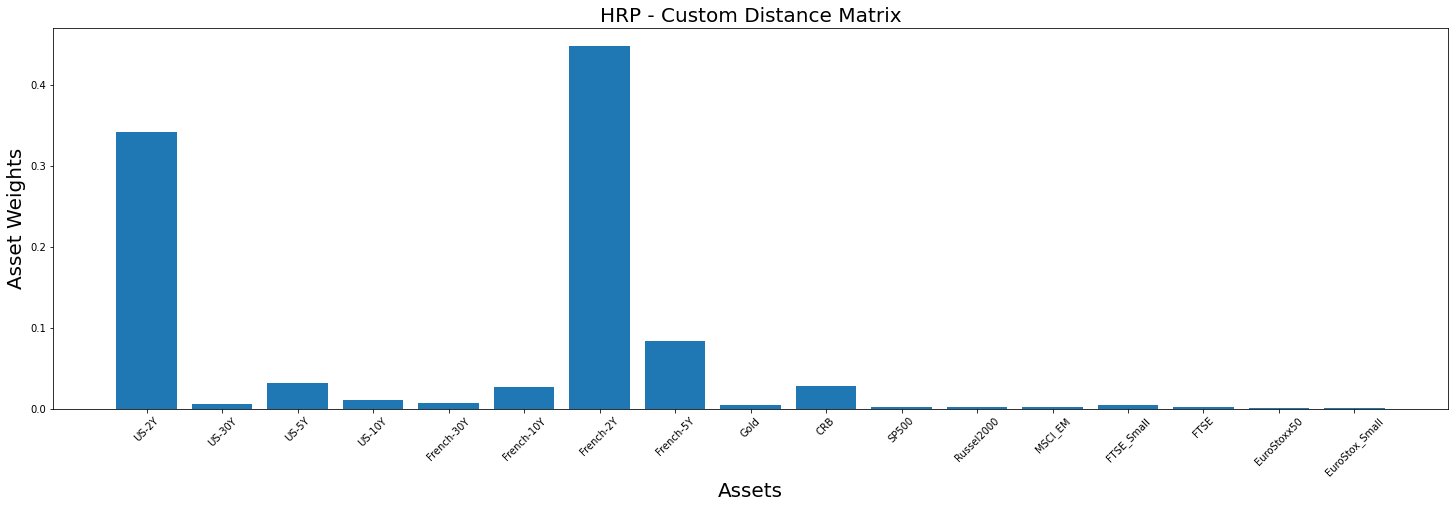

In [68]:
# plotting our optimal portfolio
hrp_distance_weights = hrp_distance.weights
y_pos = np.arange(len(hrp_distance_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_distance_weights.columns), hrp_distance_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Custom Distance Matrix', size=20)
plt.show()

### Building our Long/Short Portfolio
In this example, we will construct our Long/Short portfolio utilizing the side_weights parameter. By shorting the first four stocks in our dataset we can construct our optimal portfolio the same way we constructed it earlier, of course with the addition of the side_weight parameter to indicate which stocks we would like to short and long (-1 indicates shorting a stock and 1 indicates going long on a stock).

In [61]:
hrp_ls = HierarchicalRiskParity()
side_weights = pd.Series([1]*stock_prices.shape[1], index=stock_prices.columns)

# short the first 4 stocks
side_weights.loc[stock_prices.columns[:4]] = -1

hrp_ls.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                side_weights=side_weights)

print(side_weights)

FTSE             -1
EuroStoxx50      -1
SP500            -1
Gold             -1
French-2Y         1
French-5Y         1
French-10Y        1
French-30Y        1
US-2Y             1
US-5Y             1
US-10Y            1
US-30Y            1
Russel2000        1
EuroStox_Small    1
FTSE_Small        1
MSCI_EM           1
CRB               1
dtype: int64


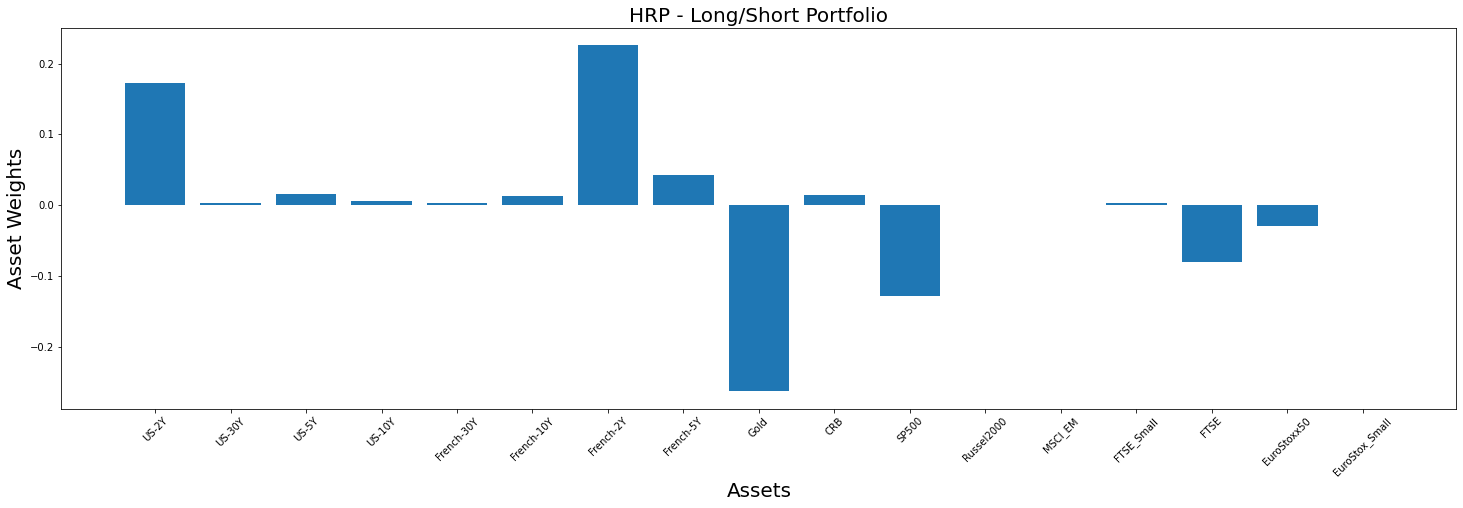

In [70]:
# plotting our optimal portfolio
hrp_ls_weights = hrp_ls.weights
y_pos = np.arange(len(hrp_ls_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_ls_weights.columns), hrp_ls_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Long/Short Portfolio', size=20)
plt.show()

## Conclusion
Throughout this tutorial notebook, users were taken through how they can construct an optimal portfolio using the Hierarchical Risk Parity algorithm powered through the MlFinLab library. Users were also shown how they can create custom use cases with this library including how to build a optimized Long/Short portfolio and use a custom distance matrix for calculations.

## Sources
Algorithm:
- __[Hierarchical Risk Parity - Hudson & Thames](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__

Documentation:
- __[Hierarchical Risk Parity - MlFinLab](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_risk_parity.html)__